In [1]:
pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [8]:
from sklearn.model_selection import train_test_split

In [2]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from datasets import load_dataset, Dataset
import pandas as pd
import ast
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback, pipeline
import os
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Disable Weights and Biases to prevent trainer from asking for API key
os.environ["WANDB_DISABLED"] = "true"

# Load roberta model
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
model = RobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=12)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [1]:
from google.colab import drive
import pandas as pd
import ast
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Define function to load LFUD+Logic data

In [2]:
data_root_path = 'gdrive/MyDrive/w266/Final Project/data'
path_to_csv = f'{data_root_path}/more_lfud_data.csv'

def load_lfud_data(path_to_csv = ''):
  '''Loads logical fallacy dataset (and optionally additional LFUD data if path_to_csv is provided).
      Arguments: path_to_csv (str): path to CSV file containing additional LFUD data.
      Returns: lfud_df (pd.DataFrame): DataFrame containing LFUD data.
  '''
  lfud_df = pd.read_csv('https://raw.githubusercontent.com/YandaGo/LFUD/main/LFUD.csv')[['proposition', 'sentence', 'fallacy_type', 'task2']]

  # Get only the first sentence of the question from task2 and set it as the context column
  lfud_df["context"] = lfud_df["task2"].apply(lambda x: ast.literal_eval(x)["question"].split('\n')[0])

  # Drop task2 column and rename the columns
  lfud_df = lfud_df.drop(columns = ["task2"]).rename(columns = {
      "fallacy_type" : "output",
      "sentence": "input"
  })

  if path_to_csv:
    # Read in additional LFUD data CSV and combine with original lfud_df
    more_lfud_df = pd.read_csv(path_to_csv)[['proposition', 'input', 'output']]
    lfud_df = pd.concat([lfud_df, more_lfud_df], ignore_index = True).apply(lambda x: x.str.strip())
    lfud_df['input'] = lfud_df['input'].str.replace("’", "'")

  return lfud_df


def preprocess_logic_all():
    logic_all = (
        pd.read_csv('https://raw.githubusercontent.com/causalNLP/logical-fallacy/main/data/edu_all.csv')
        .dropna(subset = ['source_article', 'updated_label'])
    )[lambda df: (df['updated_label'] != 'equivocation') & (df['updated_label'] != 'miscellaneous')]


    logic_all['updated_label'] = logic_all['updated_label'].replace('intentional', 'intentional fallacy')
    logic_all.loc[:, 'updated_label'] = logic_all['updated_label'].replace(
        {
            'fallacy of logic': 'deductive fallacy',
            'intentional': 'intentional fallacy'
        }
    )

    # Last 14 rows have old_label and source_article values in the wrong column. This code will shift the values in these columns one column to the right
    logic_all_to_preprocess = logic_all.tail(14).copy()
    logic_all_to_preprocess['source_article'] = logic_all_to_preprocess['old_label']

    logic_all = (pd.concat([logic_all.iloc[:-14], logic_all_to_preprocess], ignore_index = True)
                 .rename(columns = {'updated_label': 'output', 'source_article': 'input'})
                 .drop(columns = ['original_url', 'old_label', 'explanations', 'rationale'])
    )

    logic_all['input'] = logic_all['input'].str.replace('"', '')
    logic_all['input'] = logic_all['input'].str.replace('’', "'")
    logic_all = logic_all[['input', 'output']].apply(lambda x: x.str.strip())

    return logic_all


# Load the LFUD+Logic data

In [3]:
# LFUD
lfud_df = load_lfud_data(path_to_csv = f'{data_root_path}/more_lfud_data.csv')
full_context = ' \n'.join(lfud_df['context'].dropna().unique())
lfud_df.drop(columns = 'context', inplace = True)

# Logic
logic_df = preprocess_logic_all()

# Map fallacy types to integers

In [6]:
label_list = lfud_df['output'].unique().tolist()
label2id = {label: idx for idx, label in enumerate(label_list)}

lfud_df['label'] = lfud_df['output'].map(label2id)
logic_df['label'] = logic_df['output'].map(label2id)

# Drop output columns in LFUD and logic - string version of label no longer needed
lfud_df = lfud_df.drop(columns = ['output'])
logic_df = logic_df.drop(columns = ['output'])

In [13]:
label2id

{'faulty generalization': 0,
 'false causality': 1,
 'circular reasoning': 2,
 'ad populum': 3,
 'false dilemma': 4,
 'fallacy of relevance': 5,
 'ad hominem': 6,
 'appeal to emotion': 7,
 'fallacy of extension': 8,
 'fallacy of credibility': 9,
 'intentional fallacy': 10,
 'deductive fallacy': 11}

# Combine LFUD and Logic; Train-test split on LFUD propositions to avoid data leakage

In [ ]:
unique_props = lfud_df['proposition'].unique()

# Split LFUD propositions into train and test sets and do regular train-test split on Logic
lfud_train_props, lfud_val_props = train_test_split(unique_props, test_size=0.1, random_state=42)
logic_train_df, logic_val_df = train_test_split(logic_df, test_size=0.1, random_state=42)

# Filter LFUD dataset based on proposition membership
lfud_train_df = lfud_df[lfud_df['proposition'].isin(lfud_train_props)].reset_index(drop=True).drop(columns = ['proposition'])
lfud_val_df = lfud_df[lfud_df['proposition'].isin(lfud_val_props)].reset_index(drop=True).drop(columns = ['proposition'])

# Combine both LFUD and Logic
lfud_logic_train_df = pd.concat([lfud_train_df, logic_train_df], ignore_index = True)
lfud_logic_val_df = pd.concat([lfud_val_df, logic_val_df], ignore_index = True)

# Add output column temporarily for CSV purposes
lfud_logic_train_df['output'] = lfud_logic_train_df['label'].map({v:k for k, v in label2id.items()})
lfud_logic_val_df['output'] = lfud_logic_val_df['label'].map({v:k for k, v in label2id.items()})
lfud_logic_train_df.to_csv(f'{data_root_path}/lfud_logic_train.csv', index = False)
lfud_logic_val_df.to_csv(f'{data_root_path}/lfud_logic_val.csv', index = False)

# Wrap into Hugging Face Dataset
train_dataset_raw = Dataset.from_pandas(lfud_logic_train_df.drop(columns = 'output'))
eval_dataset_raw = Dataset.from_pandas(lfud_logic_val_df.drop(columns = 'output'))

# Map labels + tokenize together

In [27]:
def tokenize_and_encode(example):
    encoding = tokenizer(
        example["input"],
        padding="max_length",
        truncation=True,
        max_length=256
    )
    encoding["label"] = example["label"]
    return encoding

train_dataset = train_dataset_raw.map(tokenize_and_encode)
eval_dataset = eval_dataset_raw.map(tokenize_and_encode)

Map:   0%|          | 0/3240 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

# Final assignment for Trainer, train-validation split to monitor overfitting/hyperparameter tuning

# Define the trainer

In [33]:
training_args = TrainingArguments(
    output_dir="outputs",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="logs",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-33-1915586945.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,0.897443
2,1.755800,0.717900
3,0.684600,0.582317


TrainOutput(global_step=1215, training_loss=1.071932022659867, metrics={'train_runtime': 1860.3786, 'train_samples_per_second': 5.225, 'train_steps_per_second': 0.653, 'total_flos': 4529339457454080.0, 'train_loss': 1.071932022659867, 'epoch': 3.0})

<Axes: >

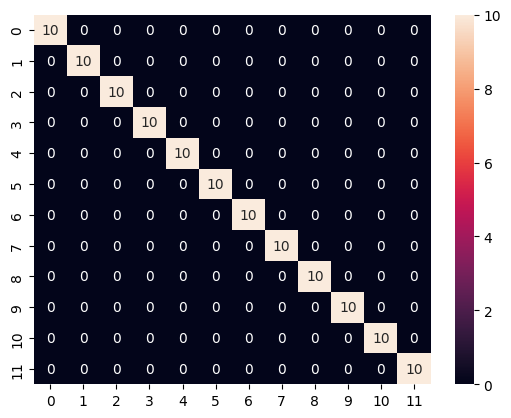

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

# Post-Training Evaluation

# Save roberta model

In [ ]:
data_root_path

'gdrive/MyDrive/w266/Final Project/data'

In [34]:
roberta_model_checkpoint_filepath = './gdrive/MyDrive/w266/Final Project/roberta_model'

# Save trained model and tokenizer
model.save_pretrained(roberta_model_checkpoint_filepath)
tokenizer.save_pretrained(roberta_model_checkpoint_filepath)

('./gdrive/MyDrive/w266/Final Project/roberta_model/tokenizer_config.json',
 './gdrive/MyDrive/w266/Final Project/roberta_model/special_tokens_map.json',
 './gdrive/MyDrive/w266/Final Project/roberta_model/vocab.json',
 './gdrive/MyDrive/w266/Final Project/roberta_model/merges.txt',
 './gdrive/MyDrive/w266/Final Project/roberta_model/added_tokens.json')

# Load model to use again

In [ ]:
roberta_model_checkpoint_filepath = './gdrive/MyDrive/w266/Final Project/roberta_model'
model = RobertaForSequenceClassification.from_pretrained(roberta_model_checkpoint_filepath)
tokenizer = RobertaTokenizer.from_pretrained(roberta_model_checkpoint_filepath)

# Load Climate and LogicClimate datasets for inference

In [35]:
# Load Climate and LogicClimate datasets for inference
logic_climate_train = pd.read_csv('https://raw.githubusercontent.com/causalNLP/logical-fallacy/main/data/climate_train.csv').dropna(subset = ['source_article', 'logical_fallacies'])
logic_climate_dev = pd.read_csv('https://raw.githubusercontent.com/causalNLP/logical-fallacy/main/data/climate_dev.csv').dropna(subset = ['source_article', 'logical_fallacies'])
logic_climate_all = pd.read_csv('https://raw.githubusercontent.com/causalNLP/logical-fallacy/main/data/climate_all.csv').dropna(subset = ['source_article', 'logical_fallacies'])

logic_train = pd.read_csv('https://raw.githubusercontent.com/causalNLP/logical-fallacy/main/data/edu_train.csv').dropna(subset = ['source_article', 'updated_label'])[lambda df: df['updated_label'] != 'miscellaneous']
logic_dev = pd.read_csv('https://raw.githubusercontent.com/causalNLP/logical-fallacy/main/data/edu_dev.csv').dropna(subset = ['source_article', 'updated_label'])[lambda df: df['updated_label'] != 'miscellaneous']
logic_all = pd.read_csv('https://raw.githubusercontent.com/causalNLP/logical-fallacy/main/data/edu_all.csv').dropna(subset = ['source_article', 'updated_label'])[lambda df: df['updated_label'] != 'miscellaneous']

logic_all['updated_label'] = logic_all['updated_label'].replace('intentional', 'intentional fallacy')
logic_climate_all['logical_fallacies'] = logic_climate_all['logical_fallacies'].replace('intentional', 'intentional fallacy')

# Drop Equivocation fallacies from Logic and LogicClimate datasets

  Li et al. (2024): due to the rather vague definition of Equivocation pro vided by Jin et al. (2022), and the scarcity of such fallacy instances in real life, GPT-4 can hardly un derstand Equivocation and generate correspond ing sentences correctly. To ensure the quality of the sentences generated by GPT-4 , we neglected Equivocation fallacy type and generated the sen tences for the rest twelve logical fallacy types.


In [36]:
# Drop Equivocation
logic_climate_all = logic_climate_all[logic_climate_all['logical_fallacies'] != 'equivocation']
logic_all = logic_all[logic_all['updated_label'] != 'equivocation']

# Map fallacy of logic to deductive fallacy.

Li et al. (2024) LFUD dataset: **Deductive fallacies** occur when there is a logical flaw in the reasoning behind the argument, such as Affirming the consequent, Denying the antecedent, Affirming a disjunct and so on.

According to [mappings.csv](https://github.com/causalNLP/logical-fallacy/blob/main/data/mappings.csv), **Fallacy of logic** is also known as a logical error, which is an error in the logical structure of an argument. For example, If A is true, then B is true. B is true. Therefore, A is true. (This is known as Affirming the consequent, and falls under the umbrella of deductive fallacy)

In [37]:
# Map fallacy of logic label to deductive fallacy
logic_climate_all.loc[:, 'logical_fallacies'] = logic_climate_all['logical_fallacies'].replace('fallacy of logic', 'deductive fallacy')
logic_all.loc[:, 'updated_label'] = logic_all['updated_label'].replace('fallacy of logic', 'deductive fallacy')

# Assert fallacy labels between LFUD and Logic+LogicClimate datasets are the same

In [ ]:
set(lfud_df['output'].unique()) == set(logic_climate_all['logical_fallacies'].unique()) == set(logic_all['updated_label'].unique())

True

In [38]:
# Wrap into Hugging Face Dataset
logic_climate_all_dataset = Dataset.from_pandas(logic_climate_all)
logic_all_dataset = Dataset.from_pandas(logic_all)

In [39]:
# Load the fallacy classification pipeline
pipe = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0  # set to 0 for GPU
)

# Apply the pipeline to the 'source_article' column
logic_climate_all['predicted_fallacy'] = logic_climate_all['source_article'].apply(lambda x: pipe(x)[0]['label'])
# logic_all['predicted_fallacy'] = logic_all['source_article'].apply(lambda x: pipe(x)[0]['label'])

# View results
display(logic_climate_all[['source_article', 'logical_fallacies', 'predicted_fallacy']])
# display(logic_all[['source_article', 'updated_label', 'predicted_fallacy']])


Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,source_article,logical_fallacies,predicted_fallacy
0,"In June last year , a severe heatwave claimed ...",intentional fallacy,LABEL_7
1,Diminishing sea ice is causing major walrus he...,intentional fallacy,LABEL_1
2,A landmark report from the United Nations ’ sc...,fallacy of credibility,LABEL_10
3,"The report “ is quite a shock , and quite conc...",fallacy of credibility,LABEL_9
4,The World Coal Association disputed the conclu...,false dilemma,LABEL_10
...,...,...,...
1345,"So why are so many people worried , indeed , p...",appeal to emotion,LABEL_3
1346,"Global warming alarmism provides them , more t...",fallacy of extension,LABEL_7
1347,"Meanwhile , over the last decade , scientists ...",intentional fallacy,LABEL_3
1348,And crony capitalists have eagerly grabbed for...,ad hominem,LABEL_3


In [ ]:
logic_climate_all.head().to_dict(orient = 'list')

{'Unnamed: 0': [0, 1, 2, 3, 4],
 'original_url': ['https://www.theguardian.com/environment/2016/aug/02/environment-climate-change-records-broken-international-report',
  'https://www.theguardian.com/environment/2016/aug/02/environment-climate-change-records-broken-international-report',
  'https://www.nytimes.com/2018/10/07/climate/ipcc-climate-report-2040.html',
  'https://www.nytimes.com/2018/10/07/climate/ipcc-climate-report-2040.html',
  'https://www.nytimes.com/2018/10/07/climate/ipcc-climate-report-2040.html'],
 'source_article': ['In June last year , a severe heatwave claimed over 1,000 lives in Karachi , Pakistan . Severe drought caused food shortages for millions of people in Ethiopia , with a lack of rainfall resulting in “ intense and widespread ” forest fires in Indonesia that belched out a vast quantity of greenhouse gas .',
  'Diminishing sea ice is causing major walrus herds to haul themselves out on to land . Arctic marine species , such as snailfish and polar cod , are

# Map predicted fallacy labels to their actual fallacy names for easier comparison

In [40]:
id2label = {v: k for k, v in label2id.items()}
logic_climate_all['predicted_fallacy_mapped'] = logic_climate_all['predicted_fallacy'].apply(lambda x: id2label[int(x.replace('LABEL_', ''))])
# logic_all['predicted_fallacy_mapped'] = logic_all['predicted_fallacy'].apply(lambda x: id2label[int(x.replace('LABEL_', ''))])

In [41]:
display(logic_climate_all[['source_article', 'logical_fallacies', 'predicted_fallacy', 'predicted_fallacy_mapped']])
# display(logic_all[['source_article', 'updated_label', 'predicted_fallacy', 'predicted_fallacy_mapped']])

,source_article,logical_fallacies,predicted_fallacy,predicted_fallacy_mapped
0,"In June last year , a severe heatwave claimed ...",intentional fallacy,LABEL_7,appeal to emotion
1,Diminishing sea ice is causing major walrus he...,intentional fallacy,LABEL_1,false causality
2,A landmark report from the United Nations ’ sc...,fallacy of credibility,LABEL_10,intentional fallacy
3,"The report “ is quite a shock , and quite conc...",fallacy of credibility,LABEL_9,fallacy of credibility
4,The World Coal Association disputed the conclu...,false dilemma,LABEL_10,intentional fallacy
...,...,...,...,...
1345,"So why are so many people worried , indeed , p...",appeal to emotion,LABEL_3,ad populum
1346,"Global warming alarmism provides them , more t...",fallacy of extension,LABEL_7,appeal to emotion
1347,"Meanwhile , over the last decade , scientists ...",intentional fallacy,LABEL_3,ad populum
1348,And crony capitalists have eagerly grabbed for...,ad hominem,LABEL_3,ad populum


In [ ]:
logic_climate_all['logical_fallacies'].value_counts(), logic_all['updated_label'].value_counts()

(logical_fallacies
 intentional fallacy       337
 appeal to emotion         141
 faulty generalization     133
 fallacy of credibility    131
 fallacy of relevance      103
 ad hominem                 96
 deductive fallacy          88
 false causality            73
 fallacy of extension       64
 ad populum                 63
 false dilemma              49
 circular reasoning          7
 Name: count, dtype: int64,
 updated_label
 faulty generalization     441
 ad hominem                302
 ad populum                232
 false causality           216
 circular reasoning        171
 appeal to emotion         167
 fallacy of relevance      162
 deductive fallacy         152
 intentional fallacy       143
 false dilemma             141
 fallacy of extension      141
 fallacy of credibility    132
 Name: count, dtype: int64)

# Check unique values of predicted_fallacy column

In [ ]:
logic_climate_all['predicted_fallacy_mapped'].unique(), logic_all['predicted_fallacy_mapped'].unique()

(array(['fallacy of relevance', 'fallacy of credibility',
        'fallacy of extension', 'false causality', 'intentional fallacy',
        'false dilemma', 'ad hominem', 'ad populum', 'deductive fallacy',
        'circular reasoning', 'appeal to emotion', 'faulty generalization'],
       dtype=object),
 array(['false dilemma', 'faulty generalization', 'ad hominem',
        'fallacy of credibility', 'ad populum', 'appeal to emotion',
        'deductive fallacy', 'false causality', 'intentional fallacy',
        'fallacy of relevance', 'fallacy of extension',
        'circular reasoning'], dtype=object))

In [ ]:
logic_climate_all['predicted_fallacy'].unique(), logic_all['predicted_fallacy'].unique()

(array(['LABEL_5', 'LABEL_9', 'LABEL_8', 'LABEL_1', 'LABEL_10', 'LABEL_4',
        'LABEL_6', 'LABEL_3', 'LABEL_11', 'LABEL_2', 'LABEL_7', 'LABEL_0'],
       dtype=object),
 array(['LABEL_4', 'LABEL_0', 'LABEL_6', 'LABEL_9', 'LABEL_3', 'LABEL_7',
        'LABEL_11', 'LABEL_1', 'LABEL_10', 'LABEL_5', 'LABEL_8', 'LABEL_2'],
       dtype=object))

Accuracy: 0.2545

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.4000    0.1667    0.2353        96
            ad populum     0.0667    0.0794    0.0725        63
     appeal to emotion     0.3137    0.3404    0.3265       141
    circular reasoning     0.1429    0.2857    0.1905         7
     deductive fallacy     0.2500    0.0341    0.0600        88
fallacy of credibility     0.3720    0.4656    0.4136       131
  fallacy of extension     0.3261    0.2344    0.2727        64
  fallacy of relevance     0.1429    0.1845    0.1610       103
       false causality     0.1981    0.5616    0.2929        73
         false dilemma     0.2000    0.0408    0.0678        49
 faulty generalization     0.1612    0.2932    0.2080       133
   intentional fallacy     0.4021    0.2255    0.2890       337

              accuracy                         0.2545      1285
             macro avg     0.2480    0.2427    0.2158      12

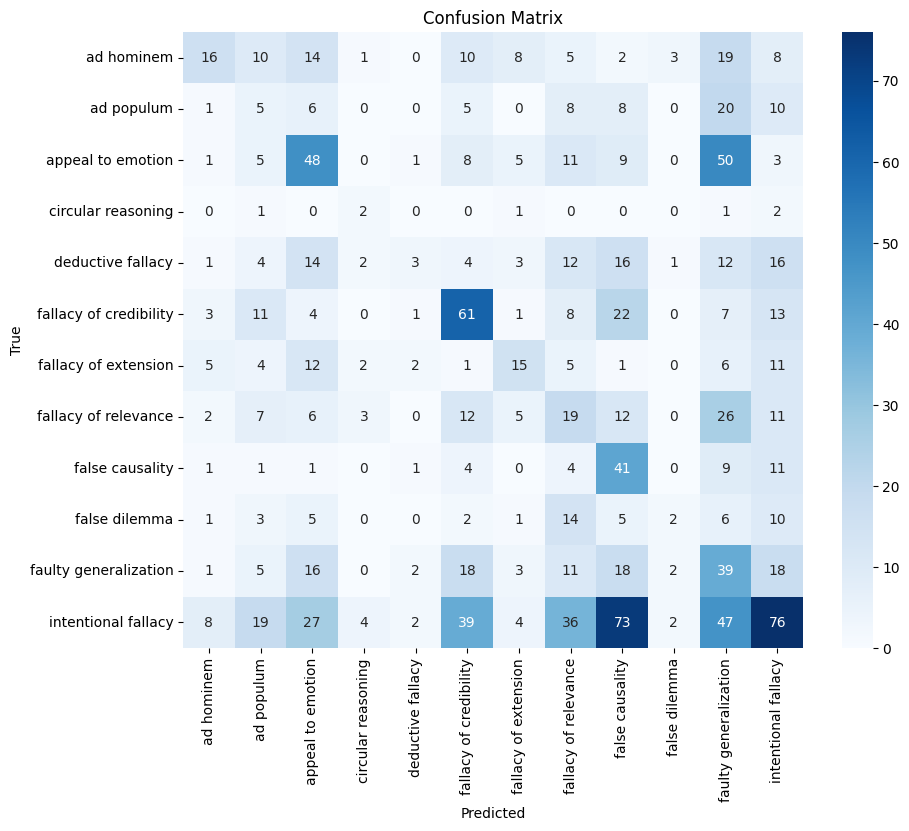

In [42]:
# Make sure your labels are strings for compatibility
y_true = logic_climate_all['logical_fallacies'].astype(str)
y_pred = logic_climate_all['predicted_fallacy_mapped'].astype(str)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Precision, Recall, F1 per class
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()